# 0. Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
from sklearn.metrics import average_precision_score

In [4]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [5]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

# 1. Data I/O

In [6]:
data=pd.read_csv('diabetes.csv',delimiter=',')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 2. Data Exploration

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [9]:
data['Outcome']=data['Outcome'].map({1:'Has Diabetes',0:'No Diabetes'})

In [10]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

In [38]:
axis_font = {'fontname':'Arial', 'size':'16'}

/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


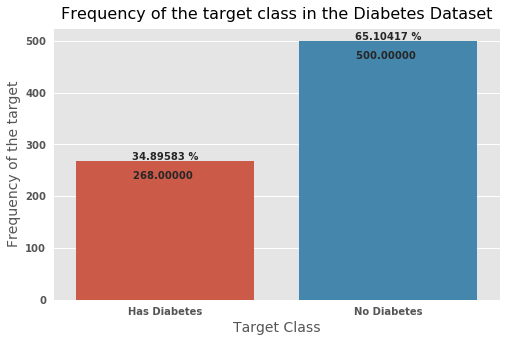

In [12]:
import matplotlib.style as style
style.use('ggplot')
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Outcome', data=data);
total=float(len(data))
plt.title('Frequency of the target class in the Diabetes Dataset',**title_font)
plt.ylabel('Frequency of the target',**axis_font)
plt.xlabel('Target Class',**axis_font)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")

/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


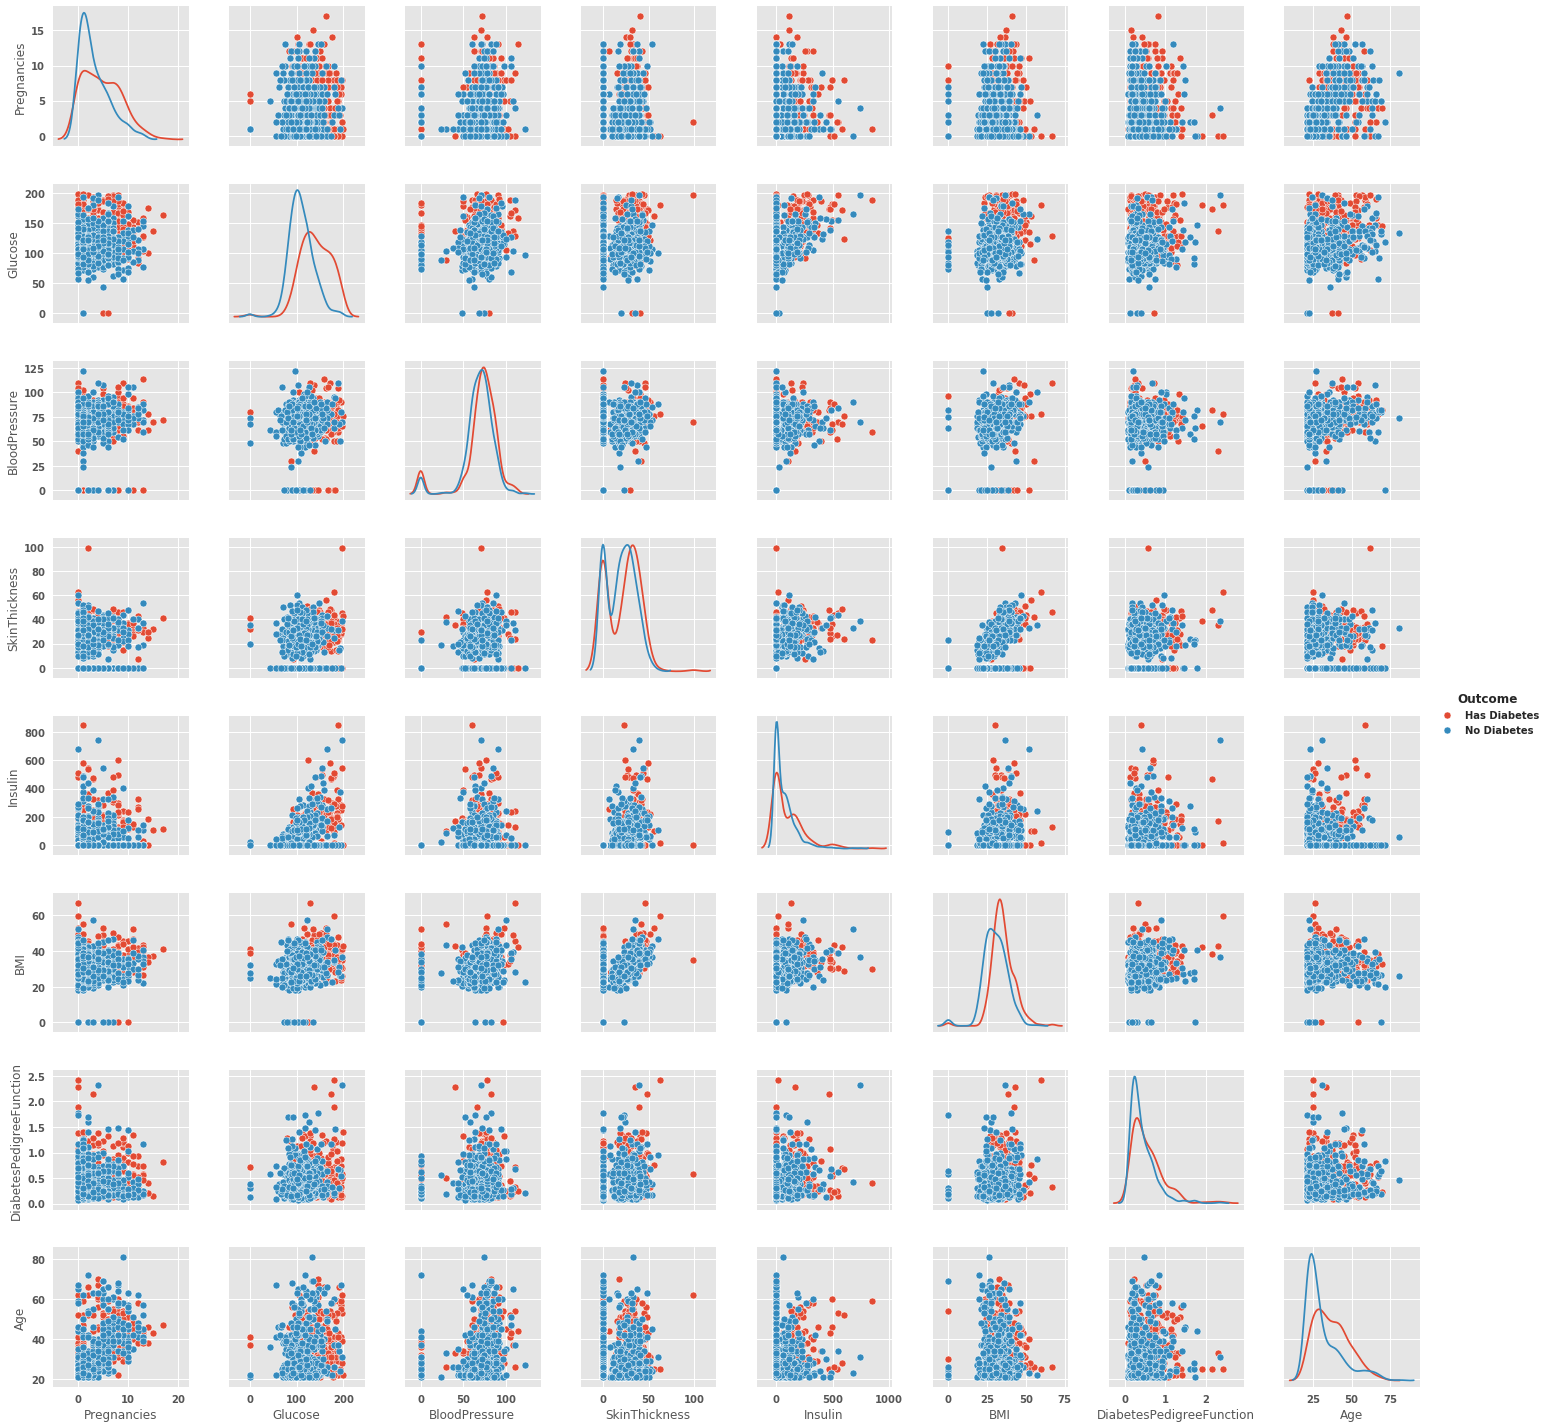

In [13]:
sns.pairplot(data, hue="Outcome",diag_kind="kde")

/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


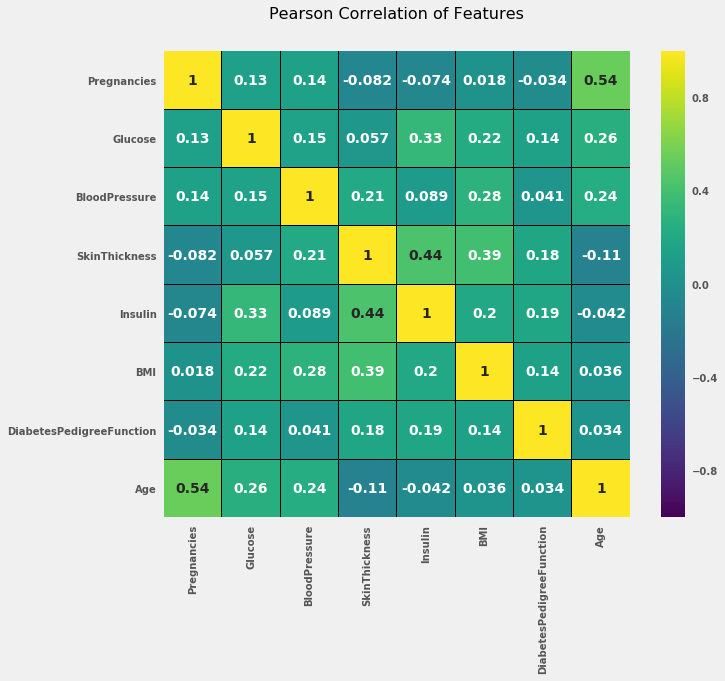

In [14]:
data_num=data.drop('Outcome',axis=1)
colormap = plt.cm.viridis
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, **title_font)
sns.heatmap(data_num.astype(float).corr(),linewidths=0.05,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=True);

In [15]:
plt.style.use('ggplot')

# 3. Data preprocessing

In [16]:
X=data.drop(['Outcome'],axis=1)
Y=data[['Outcome']]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0,stratify=Y.Outcome)

In [17]:
xcols=X_train.columns.tolist()
X_train=StandardScaler().fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=xcols)

xcols=X_test.columns.tolist()
X_test=StandardScaler().fit_transform(X_test)
X_test=pd.DataFrame(X_test,columns=xcols)

In [18]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.829844,-1.235253,-0.089432,-1.299189,-0.671327,-1.712243,0.492470,-0.517911
1,1.238989,1.468423,1.946297,1.547758,1.309554,0.673676,-0.918723,0.846519
2,-0.829844,-0.430588,-0.518006,1.547758,0.855066,0.415407,-0.150099,-0.773742
3,-1.125391,0.213145,-0.089432,-0.123276,0.872217,-0.199521,2.850606,-0.688465
4,-0.829844,-0.688081,0.231999,-0.556507,-0.276866,-1.552362,-0.967915,-0.432634


In [19]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.608403,-0.794822,-3.082637,-1.255337,-0.787400,-0.247937,-0.008512,-0.245859
1,0.608403,1.222960,-0.223952,-1.255337,-0.787400,-1.061899,-0.926993,1.359907
2,-1.210900,-0.482208,0.882635,-0.115388,0.175851,-0.321933,0.543145,-0.583915
3,0.001969,0.654570,0.882635,-1.255337,-0.787400,1.853567,0.400965,-1.006485
4,1.821272,0.825087,0.790420,1.963342,1.386796,0.906410,1.413284,1.444421


In [20]:
# mapping back
Y_train['Outcome']=Y_train['Outcome'].map({'Has Diabetes':1,'No Diabetes':0})
Y_test['Outcome']=Y_test['Outcome'].map({'Has Diabetes':1,'No Diabetes':0})

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# visualizing first-2 principal components using the train set
pca=PCA(n_components=2)
X_train_pca=pca.fit_transform(X_train)

In [22]:
X_train_pca=pd.DataFrame(X_train_pca,columns=['PC1','PC2'])

In [23]:
X_train_pca['Outcome']=Y_train

/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


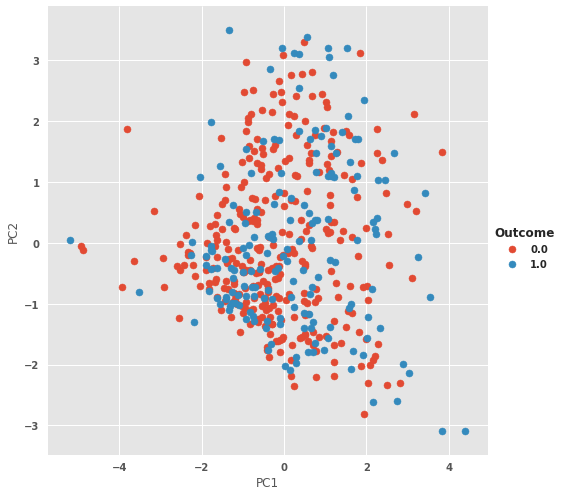

In [24]:
sns.FacetGrid(X_train_pca, hue="Outcome", size=7).map(plt.scatter, "PC1", "PC2").add_legend()

# 4. Model Building

# 4.0 Utility Functions

In [71]:
import itertools

def plot_confusion_matrix(axd,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.sca(axd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title,**title_font)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label',**axis_font)
    plt.xlabel('Predicted label',**axis_font)

In [46]:
def model_fitting_and_post_processing(clf,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=[0,1],cross_val=False):
    #average precision for the precision recall curves
    # passing dataframes into the function
    clf.fit(X_train.values,Y_train.values.ravel())
    #print(clf.best_estimator_)
    if cross_val:
        clf=clf.best_estimator_
        print('\n')
        print(clf)
        print('\n')
    predictions=clf.predict(X_test.values)
    #decision function
    try:
        Y_score = clf.decision_function(X_test.values)
    except:
        Y_score = clf.predict_proba(X_test.values)[:,1]
    #Y_score=clf.decision_function(X_test.values)
    # printing the accuracy
    print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
    # predicting probabilities
    post_probab_predictions=clf.predict_proba(X_test.values)
    # assiging the probability
    post_probab_predictions=post_probab_predictions[:,1]
    # now subplotting
    fig, axes=plt.subplots(2,2,figsize=(14,10))
    # Class Distribution
    plt.sca(axes[0,0])
    data_train=X_train.copy()
    data_train['Outcome']=Y_train
    data_train['Outcome']=data_train['Outcome'].map({1.0:'Has Diabetes',0.0:'No Diabetes'})
    ax=sns.countplot(x='Outcome', data=data_train);
    total=float(len(data_train))
    plt.title('Frequency of the target class in the Training-set',**title_font)
    plt.ylabel('Frequency of the target',**axis_font)
    plt.xlabel('Target Class',**axis_font)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
        ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(Y_test.values,predictions)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
    axes[0,1].grid('off')

    # ROC CURVE
    fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
    roc_auc = auc(fpr,tpr)
    plt.style.use('ggplot')
    title_gp='ROC for '+clf_name+' Classifier'
    axes[1,0].set_title(title_gp,**title_font)
    axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    axes[1,0].legend(loc='lower right')
    axes[1,0].plot([0,1],[0,1],'r--')
    axes[1,0].set_ylabel('True Positive Rate',**axis_font)
    axes[1,0].set_xlabel('False Positive Rate',**axis_font)
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
    average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
    axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
    axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_xlabel('Recall',**axis_font)
    axes[1,1].set_ylabel('Precision',**axis_font)
    title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
    axes[1,1].set_title(title_gp,**title_font)


    fig.tight_layout()
    print('\n')
    print('----------------------- Complete Classification Report -----------------------\n')
    print(classification_report(Y_test.values,predictions))
    print('\n')
    print('--------------------------- Post-processed Plots --------------------------\n')    
    return predictions

# 4.0 Logisitic Regression - Benchmark

The accruacy of Logistic Reg on the Test set:  0.7922077922077922


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       100
          1       0.78      0.57      0.66        54

avg / total       0.79      0.79      0.78       154



--------------------------- Post-processed Plots --------------------------



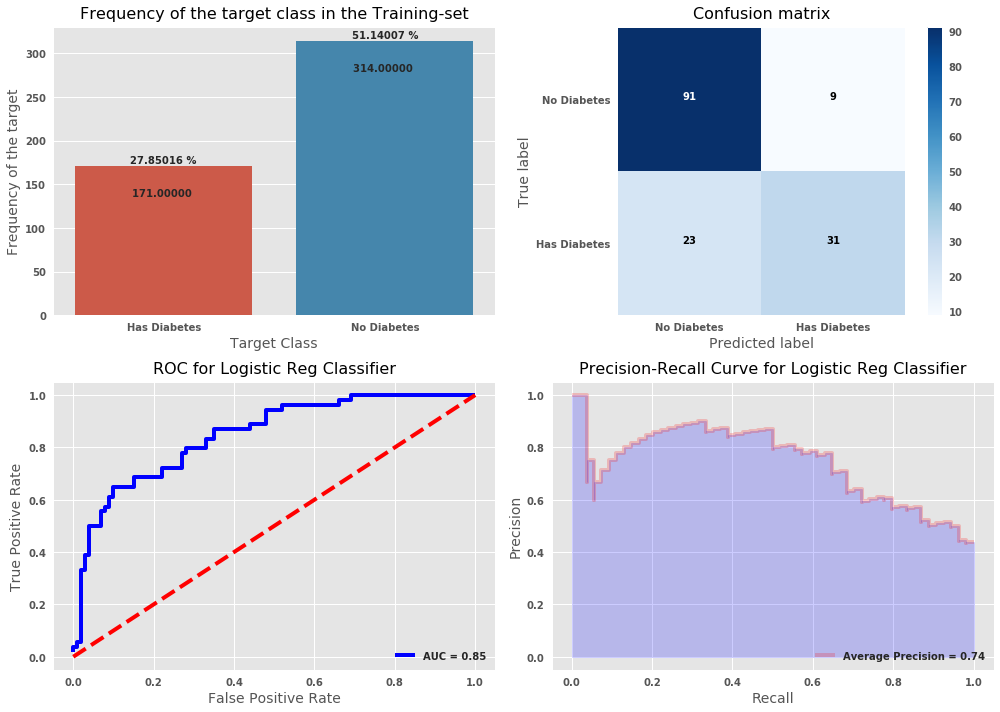

In [27]:
from sklearn.linear_model import LogisticRegression
clf_log=LogisticRegression()
pred_log=model_fitting_and_post_processing(clf_log,X_train,Y_train,X_test,Y_test,clf_name='Logistic Reg',class_names=['No Diabetes','Has Diabetes'])

# 4.1 Using SVM without Imbalanced learning approach

The accruacy of SVM on the Test set:  0.7922077922077922


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.79      0.92      0.85       100
          1       0.79      0.56      0.65        54

avg / total       0.79      0.79      0.78       154



--------------------------- Post-processed Plots --------------------------



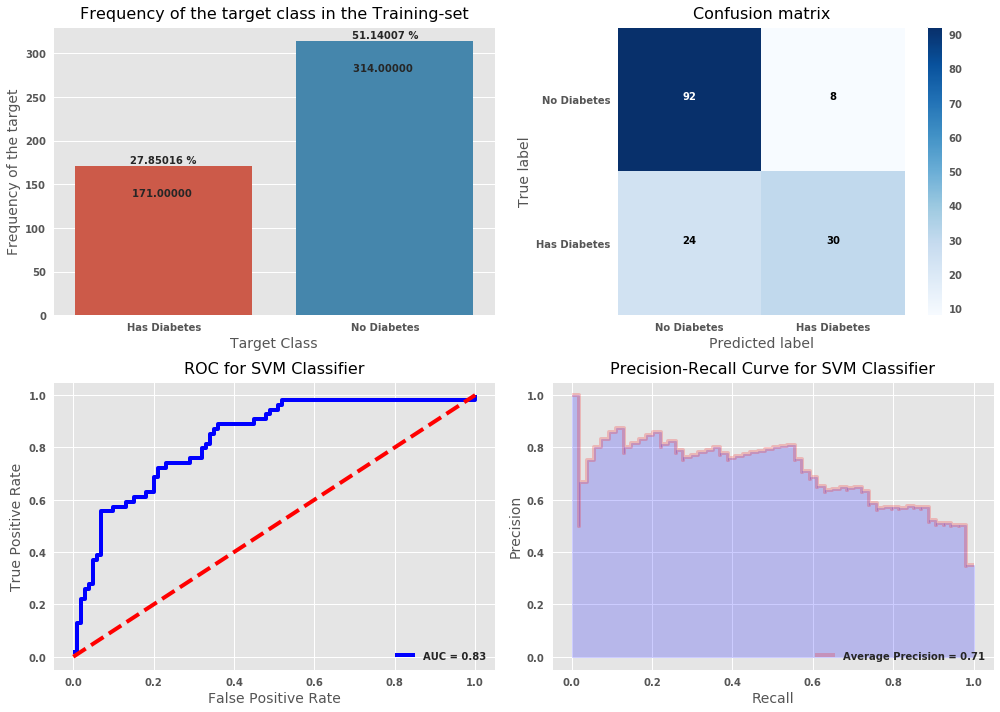

In [28]:
clf_svm=SVC(kernel='rbf',probability=True)
preds_svm=model_fitting_and_post_processing(clf_svm,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=['No Diabetes','Has Diabetes'])

# 4.2 Random Forests

The accruacy of Random Forests on the Test set:  0.7662337662337663


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.79      0.88      0.83       100
          1       0.71      0.56      0.63        54

avg / total       0.76      0.77      0.76       154



--------------------------- Post-processed Plots --------------------------



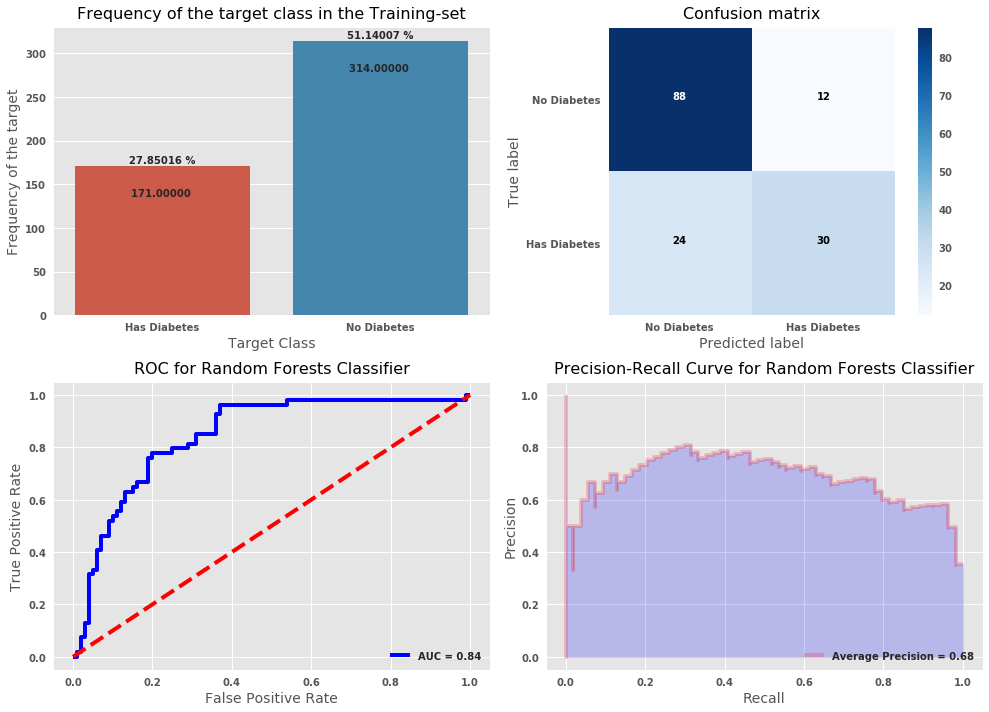

In [29]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=5,random_state=0)
preds_rf=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['No Diabetes','Has Diabetes'])

# 4.3) XGBoost

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


The accruacy of XGBoost on the Test set:  0.7662337662337663


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.80      0.86      0.83       100
          1       0.70      0.59      0.64        54

avg / total       0.76      0.77      0.76       154



--------------------------- Post-processed Plots --------------------------



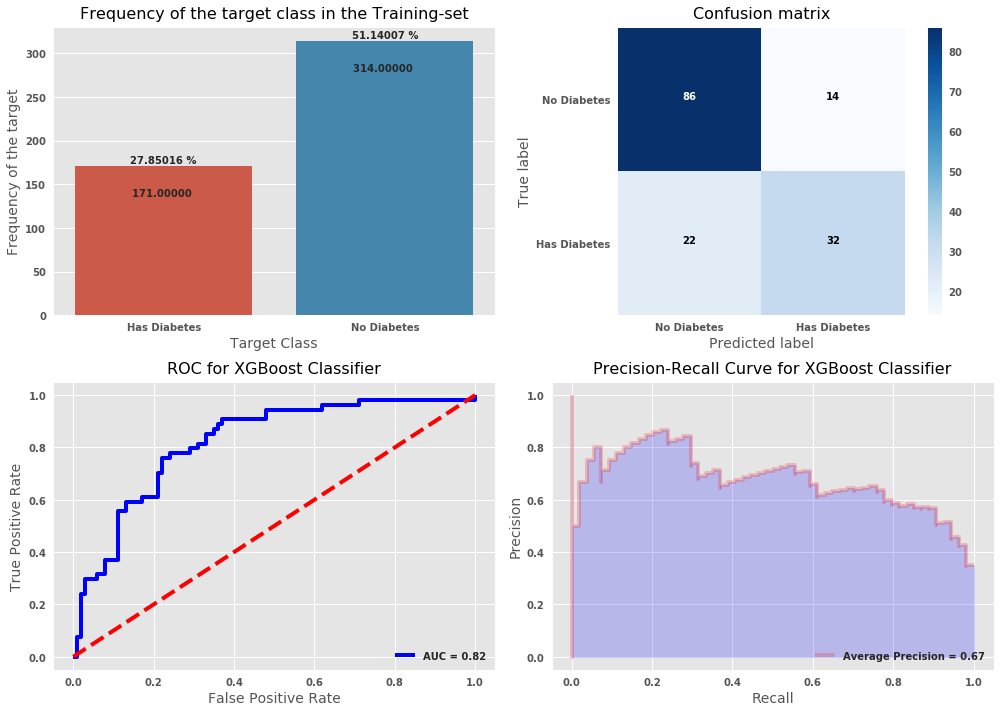

In [30]:
clf_xgbc=xgb.XGBClassifier(n_estimators=200,max_depth=5,random_state=0)
preds_xgbc=model_fitting_and_post_processing(clf_xgbc,X_train,Y_train,X_test,Y_test,clf_name='XGBoost',class_names=['No Diabetes','Has Diabetes'])

# 5. Using SVM-SMOTE and SMOTE-ENN

## 5.1) Using SVM-SMOTE

In [31]:
# resample the data
clf_svm_smote=SMOTE(random_state=0,kind='svm',svm_estimator=SVC(kernel='rbf'))
X_resampled,Y_resampled=clf_svm_smote.fit_sample(X_train,Y_train.values.ravel())

In [32]:
data_resampled=pd.DataFrame(X_resampled,columns=xcols)
data_resampled['Outcome']=Y_resampled

In [33]:
data_resampled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.829844,-1.235253,-0.089432,-1.299189,-0.671327,-1.712243,0.492470,-0.517911,0
1,1.238989,1.468423,1.946297,1.547758,1.309554,0.673676,-0.918723,0.846519,1
2,-0.829844,-0.430588,-0.518006,1.547758,0.855066,0.415407,-0.150099,-0.773742,0
3,-1.125391,0.213145,-0.089432,-0.123276,0.872217,-0.199521,2.850606,-0.688465,1
4,-0.829844,-0.688081,0.231999,-0.556507,-0.276866,-1.552362,-0.967915,-0.432634,0


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


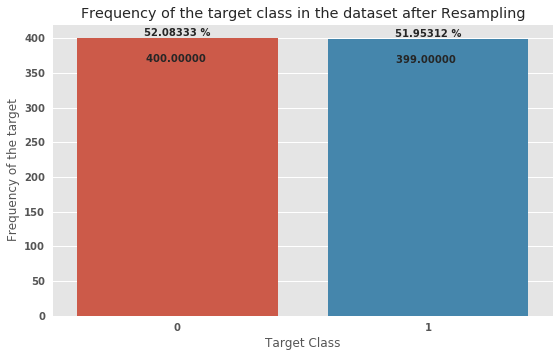

In [34]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Outcome', data=data_resampled);
total=float(len(data))
plt.title('Frequency of the target class in the dataset after Resampling')
plt.ylabel('Frequency of the target')
plt.xlabel('Target Class')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")

In [35]:
X_rtrain=data_resampled.drop(['Outcome'],axis=1)
Y_rtrain=data_resampled[['Outcome']]
#X_rtrain,X_rtest,Y_rtrain,Y_rtest=train_test_split(X_rt,Y_rt,test_size=0.2,random_state=0,stratify=Y_rt.Outcome)

In [36]:
X_rtrain=StandardScaler().fit_transform(X_rtrain)
X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)

# test set should not be resampled
X_rtest=StandardScaler().fit_transform(X_test)
X_rtest=pd.DataFrame(X_rtest,columns=xcols)

The accruacy of SVM with SMOTE on the Test set:  0.7662337662337663


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.91      0.71      0.80       100
          1       0.62      0.87      0.72        54

avg / total       0.81      0.77      0.77       154



--------------------------- Post-processed Plots --------------------------



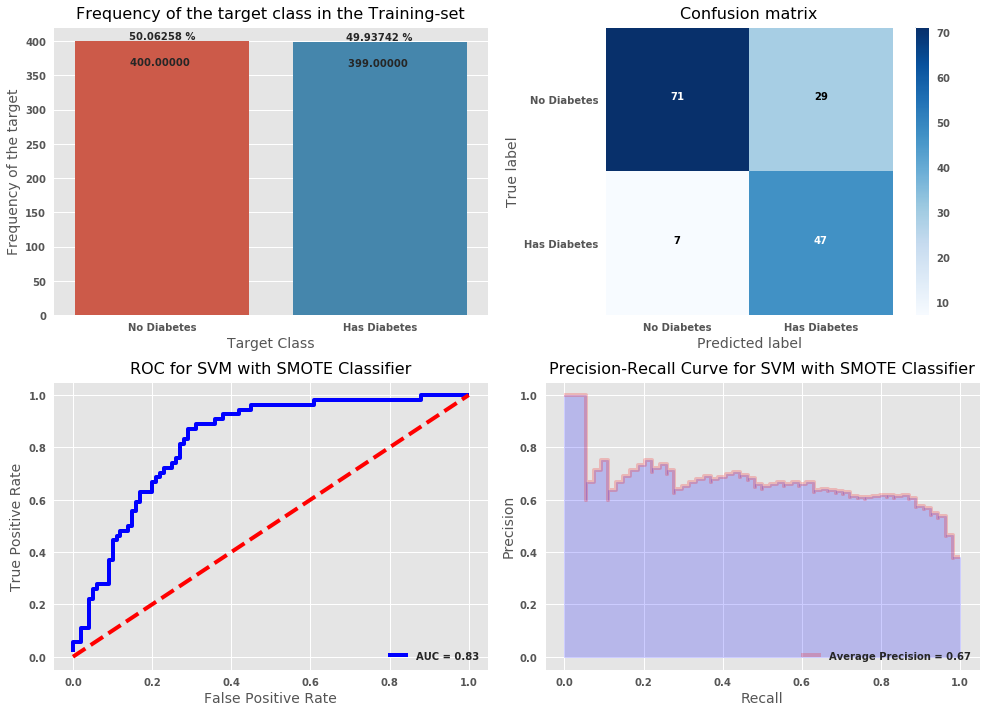

In [37]:
#clf_svm.fit(X_rtrain.values,Y_rtrain.values)
r_predictions=model_fitting_and_post_processing(clf_svm,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='SVM with SMOTE',class_names=['No Diabetes','Has Diabetes'])

## 5.2) Using SVM-SMOTE-ENN

In [39]:
# resample the data
clf_svm_smote_enn=SMOTEENN(random_state=0,kind_smote='svm')
X_resampled,Y_resampled=clf_svm_smote_enn.fit_sample(X_train,Y_train)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [40]:
data_resampled=pd.DataFrame(X_resampled,columns=xcols)
data_resampled['Outcome']=Y_resampled

/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


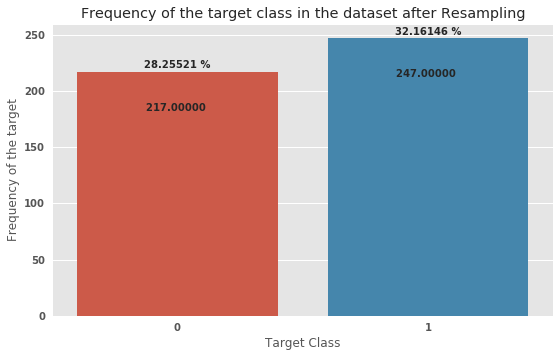

In [41]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Outcome', data=data_resampled);
total=float(len(data))
plt.title('Frequency of the target class in the dataset after Resampling')
plt.ylabel('Frequency of the target')
plt.xlabel('Target Class')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")

In [42]:
X_rtrain=data_resampled.drop(['Outcome'],axis=1)
Y_rtrain=data_resampled[['Outcome']]
#X_rtrain,X_rtest,Y_rtrain,Y_rtest=train_test_split(X_rt,Y_rt,test_size=0.2,random_state=0,stratify=Y_rt.Outcome)

In [43]:
X_rtrain=StandardScaler().fit_transform(X_rtrain)
X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)
#X_rtest=StandardScaler().fit_transform(X_rtest)
#X_rtest=pd.DataFrame(X_rtest,columns=xcols)

In [44]:
# mapping back
#Y_rtrain['Outcome']=Y_rtrain['Outcome'].map({'Has Diabetes':1,'No Diabetes':0})
#Y_rtest['Outcome']=Y_rtest['Outcome'].map({'Has Diabetes':1,'No Diabetes':0})

The accruacy of SVM with SMOTE-ENN on the Test set:  0.7207792207792207


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.91      0.63      0.75       100
          1       0.56      0.89      0.69        54

avg / total       0.79      0.72      0.73       154



--------------------------- Post-processed Plots --------------------------



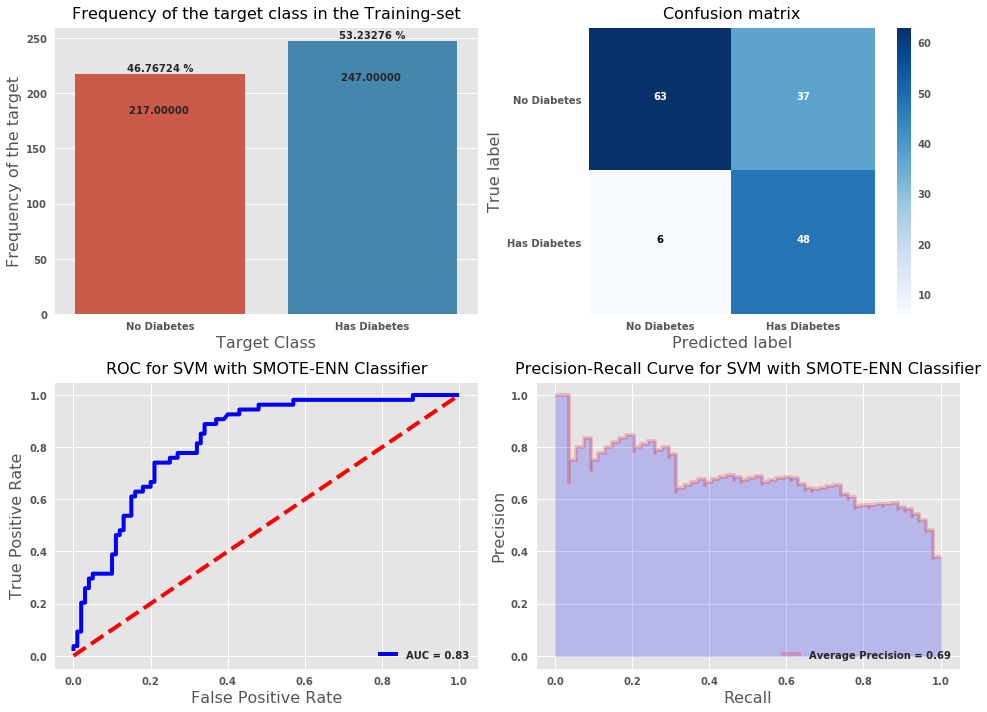

In [47]:
#clf_svm.fit(X_rtrain.values,Y_rtrain.values)
r_predictions=model_fitting_and_post_processing(clf_svm,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='SVM with SMOTE-ENN',class_names=['No Diabetes','Has Diabetes'])

# 5.3 Using SVM-ADASYN

In [48]:
# resample the data
clf_svm_smote_ada=ADASYN(random_state=0)
X_resampled,Y_resampled=clf_svm_smote_ada.fit_sample(X_train,Y_train)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
data_resampled=pd.DataFrame(X_resampled,columns=xcols)
data_resampled['Outcome']=Y_resampled

/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


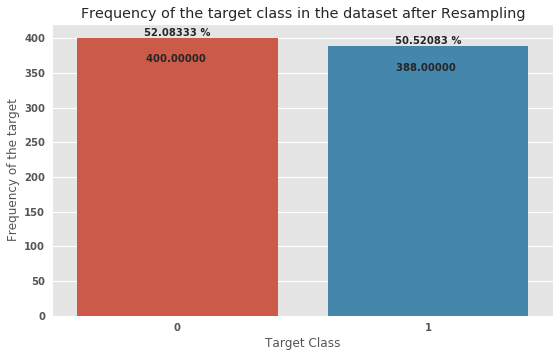

In [50]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Outcome', data=data_resampled);
total=float(len(data))
plt.title('Frequency of the target class in the dataset after Resampling')
plt.ylabel('Frequency of the target')
plt.xlabel('Target Class')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")

In [51]:
X_rtrain=data_resampled.drop(['Outcome'],axis=1)
Y_rtrain=data_resampled[['Outcome']]
#X_rtrain,X_rtest,Y_rtrain,Y_rtest=train_test_split(X_rt,Y_rt,test_size=0.2,random_state=0,stratify=Y_rt.Outcome)

In [52]:
X_rtrain=StandardScaler().fit_transform(X_rtrain)
X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)
#X_rtest=StandardScaler().fit_transform(X_rtest)
#X_rtest=pd.DataFrame(X_rtest,columns=xcols)

In [53]:
# mapping back
#Y_rtrain['Outcome']=Y_rtrain['Outcome'].map({'Has Diabetes':1,'No Diabetes':0})
#Y_rtest['Outcome']=Y_rtest['Outcome'].map({'Has Diabetes':1,'No Diabetes':0})

The accruacy of SVM with ADASYN on the Test set:  0.7467532467532467


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.90      0.69      0.78       100
          1       0.60      0.85      0.70        54

avg / total       0.79      0.75      0.75       154



--------------------------- Post-processed Plots --------------------------



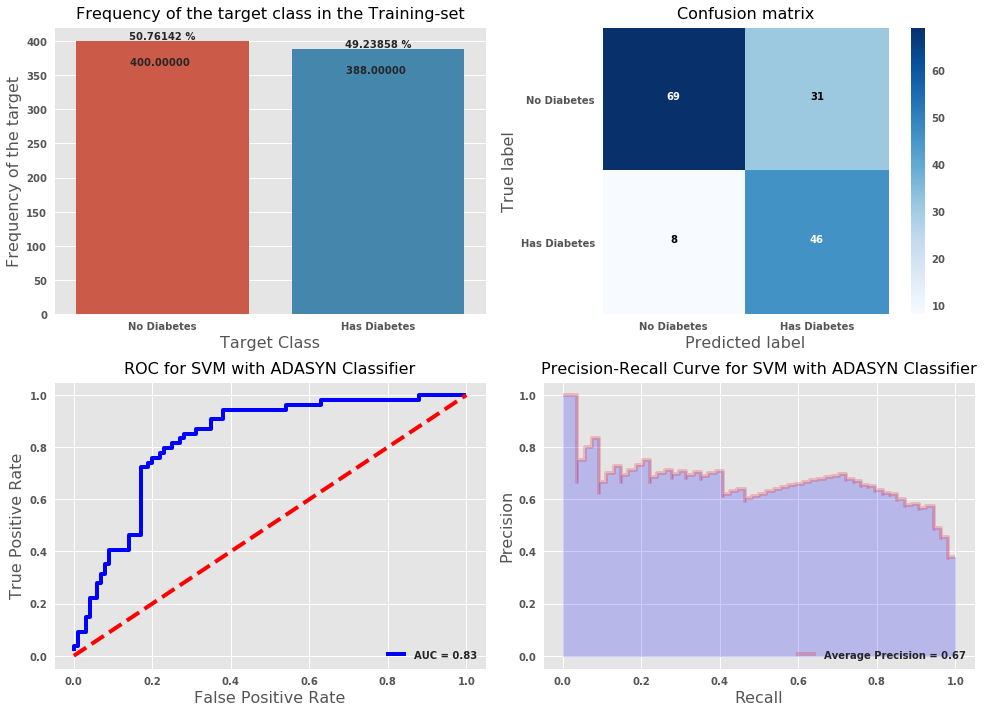

In [54]:
#clf_svm.fit(X_rtrain.values,Y_rtrain.values)
r_predictions=model_fitting_and_post_processing(clf_svm,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='SVM with ADASYN',class_names=['No Diabetes','Has Diabetes'])

# 6. Using Random Forests with ADASYN

In [55]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=5,random_state=0)

The accruacy of RF with ADASYN on the Test set:  0.7727272727272727


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.87      0.76      0.81       100
          1       0.64      0.80      0.71        54

avg / total       0.79      0.77      0.78       154



--------------------------- Post-processed Plots --------------------------



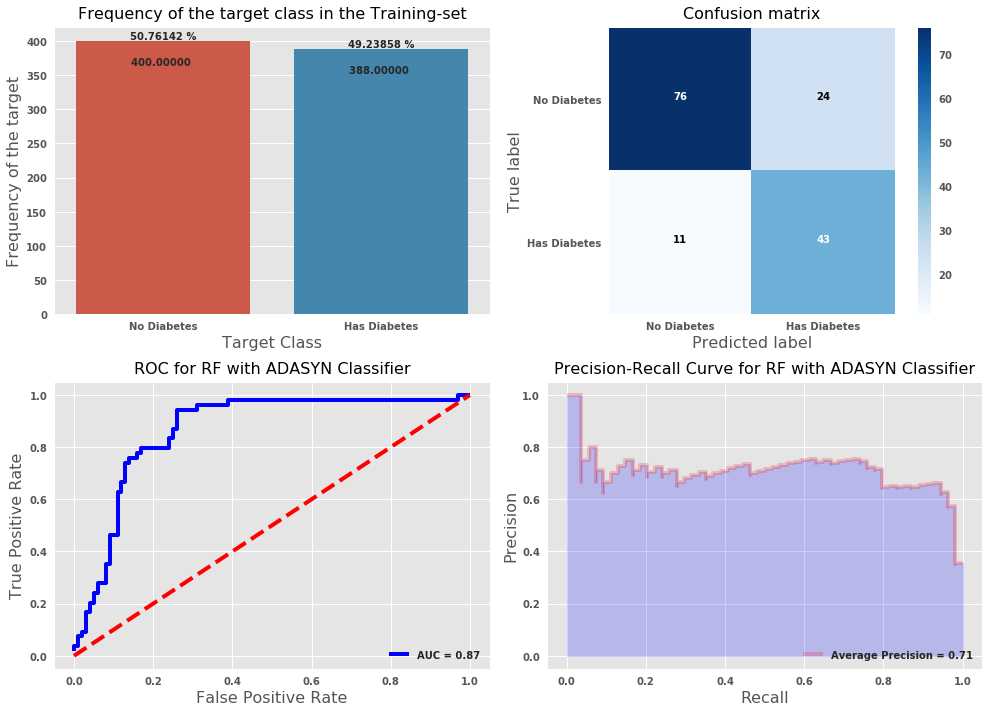

In [56]:
#clf_rf.fit(X_rtrain.values,Y_rtrain.values)
r_predictions=model_fitting_and_post_processing(clf_rf,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='RF with ADASYN',class_names=['No Diabetes','Has Diabetes'])

# 6.2 XGBoost with ADASYN

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


The accruacy of XGBoost with ADASYN on the Test set:  0.7662337662337663


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.89      0.73      0.80       100
          1       0.62      0.83      0.71        54

avg / total       0.80      0.77      0.77       154



--------------------------- Post-processed Plots --------------------------



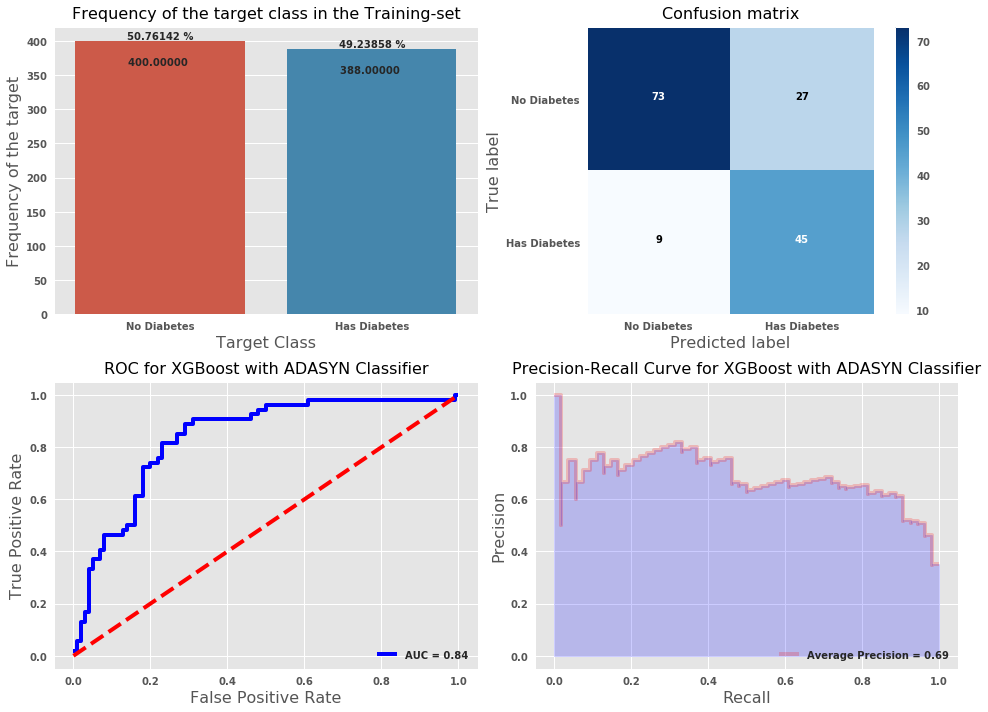

In [57]:
#clf_xgbc.fit(X_rtrain.values,Y_rtrain.values)
r_predictions=model_fitting_and_post_processing(clf_xgbc,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with ADASYN',class_names=['No Diabetes','Has Diabetes'])

# 7. Cross-validation 

## 7.1 CV with Random Forests

In [58]:
from sklearn.metrics import f1_score,make_scorer
scored=make_scorer(f1_score)

In [59]:
X_train.reset_index(inplace=True)
X_train.drop('index',axis=1,inplace=True)
Y_train.reset_index(inplace=True)
Y_train.drop('index',axis=1,inplace=True)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    4.7s finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=321, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forests with CV on the Test set:  0.7857142857142857


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.80      0.90      0.85       100
          1       0.76      0.57      0.65        54

avg / total       0.78      0.79      0.78       154



--------------------------- Post-processed Plots --------------------------



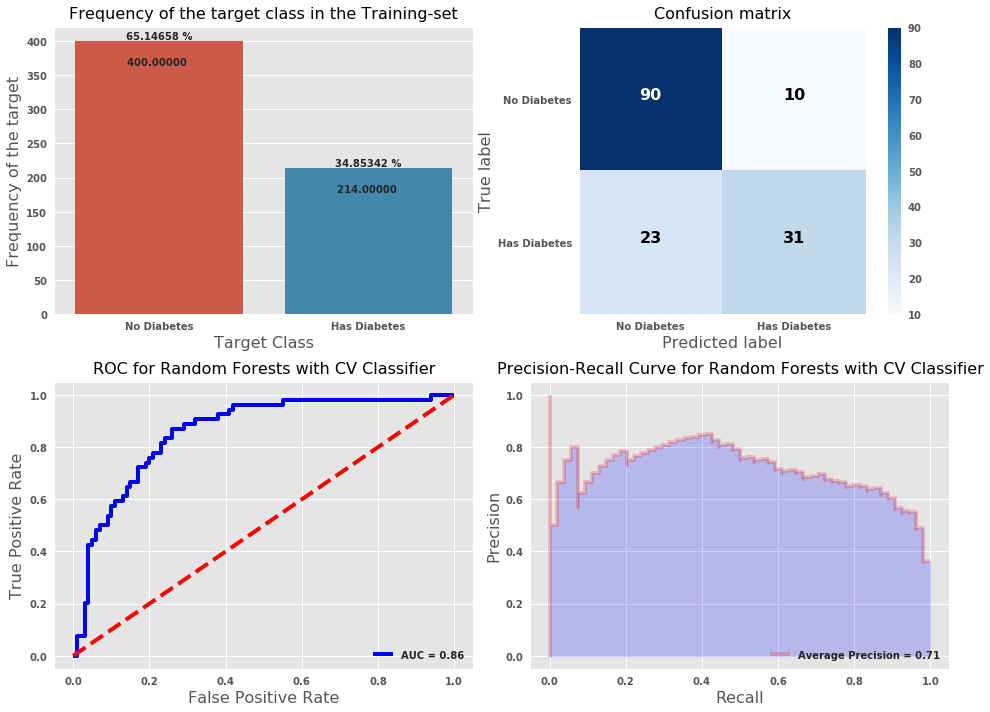

In [76]:
clf_rf=RandomForestClassifier(random_state=0)
params_rf = {"n_estimators": st.randint(300, 500),"max_depth": st.randint(6, 8),'min_samples_split':st.randint(2,6)}
rfrscv=RandomizedSearchCV(clf_rf, param_distributions=params_rf,n_iter=10,n_jobs=8,scoring=scored,cv=5,verbose=True,random_state=0)
rf_predictions=model_fitting_and_post_processing(rfrscv,X_train,Y_train,X_test,Y_test,clf_name='Random Forests with CV',class_names=['No Diabetes','Has Diabetes'],cross_val=True)

## 7.2. ADACYN + CV with Random Forests

In [61]:
X_rtrain.reset_index(inplace=True)
X_rtrain.drop('index',axis=1,inplace=True)
Y_rtrain.reset_index(inplace=True)
Y_rtrain.drop('index',axis=1,inplace=True)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    5.1s finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=321, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forest+ADASYN+CV on the Test set:  0.7987012987012987


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.91      0.77      0.83       100
          1       0.67      0.85      0.75        54

avg / total       0.82      0.80      0.80       154



--------------------------- Post-processed Plots --------------------------



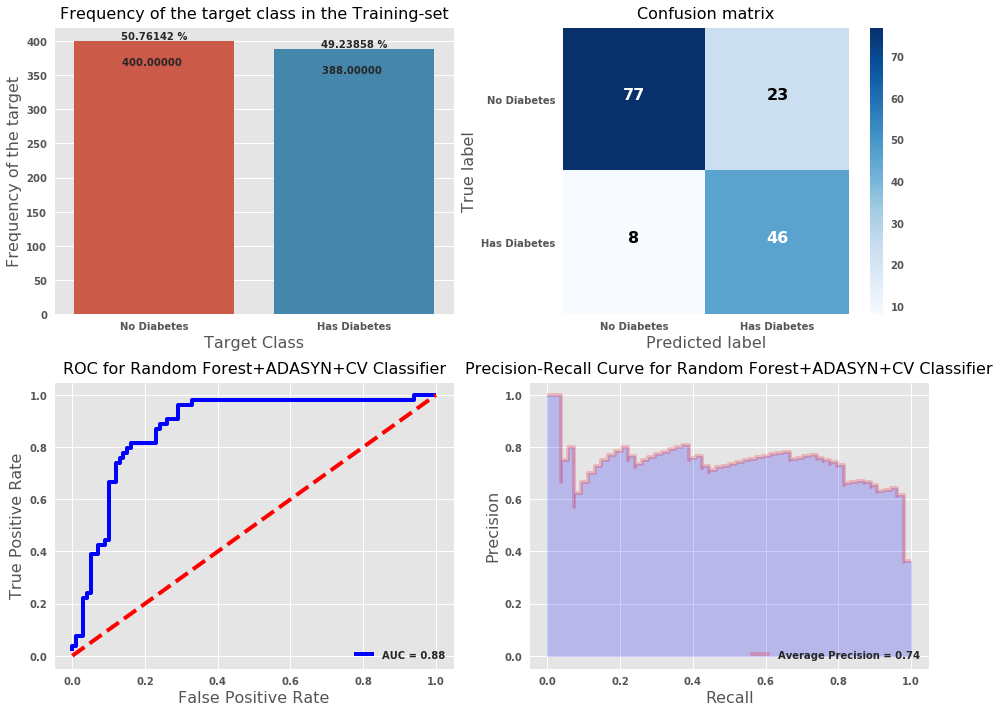

In [77]:
# with resampling
rf_predictions=model_fitting_and_post_processing(rfrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Random Forest+ADASYN+CV',class_names=['No Diabetes','Has Diabetes'],cross_val=True)

## 7.3) CV with XGBoost

In [63]:
params_xgb={'learning_rate':st.uniform(0.01,0.2), 'n_estimators':st.randint(80,500), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,10)}

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01516147256443542,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=241, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


The accruacy of XGBoost with CV on the Test set:  0.7662337662337663


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.80      0.86      0.83       100
          1       0.70      0.59      0.64        54

avg / total       0.76      0.77      0.76       154



--------------------------- Post-processed Plots --------------------------



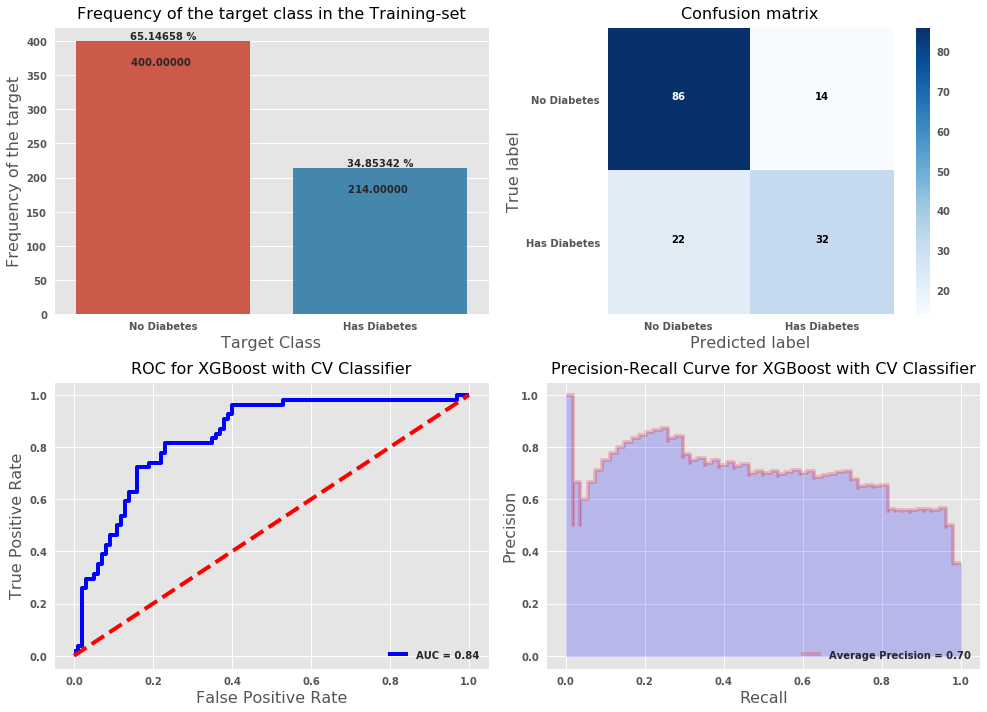

In [64]:
clf_xgb=xgb.XGBClassifier(random_state=0)
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=5,verbose=True)
xgb_predictions=model_fitting_and_post_processing(xgbrscv,X_train,Y_train,X_test,Y_test,clf_name='XGBoost with CV',class_names=['No Diabetes','Has Diabetes'],cross_val=True)

## 7.4 ADASYN+CV with XGBoost

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.18893630791232038,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=139, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)


The accruacy of XGBoost with ADASYN and CV on the Test set:  0.7792207792207793


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.87      0.78      0.82       100
          1       0.66      0.78      0.71        54

avg / total       0.79      0.78      0.78       154



--------------------------- Post-processed Plots --------------------------



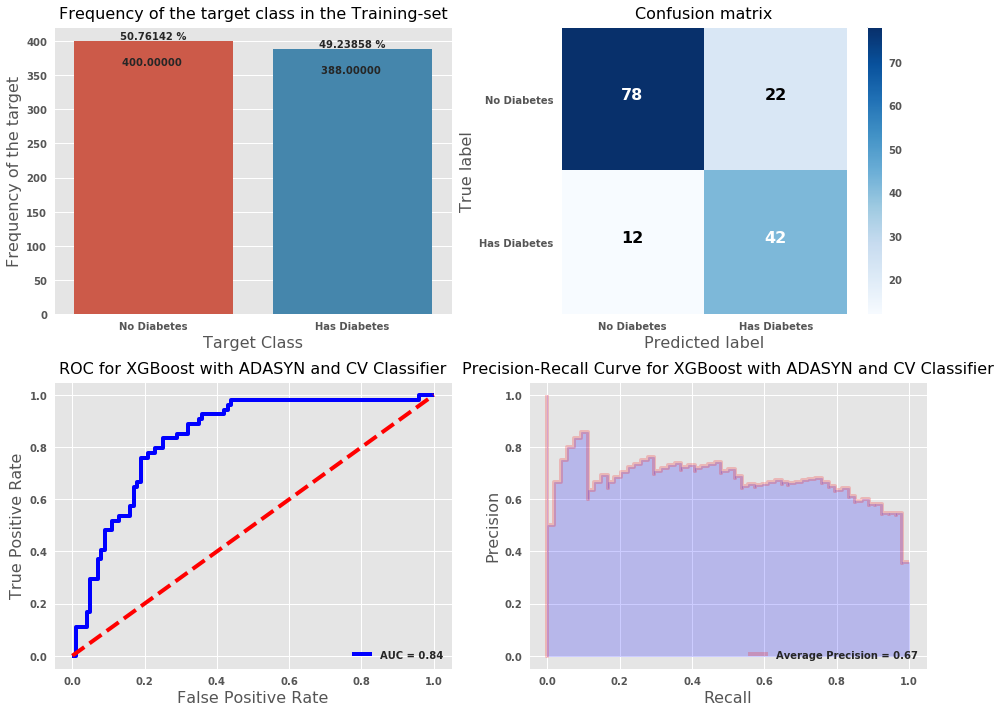

In [75]:
gbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=5,verbose=True,random_state=0)
xgb_predictions=model_fitting_and_post_processing(xgbrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with ADASYN and CV',class_names=['No Diabetes','Has Diabetes'],cross_val=True)

## 7.5 Logistic Reg with CV 

The accruacy of Logistic reg CV + ADASYN on the Test set:  0.7402597402597403


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       0.87      0.71      0.78       100
          1       0.60      0.80      0.68        54

avg / total       0.77      0.74      0.75       154



--------------------------- Post-processed Plots --------------------------



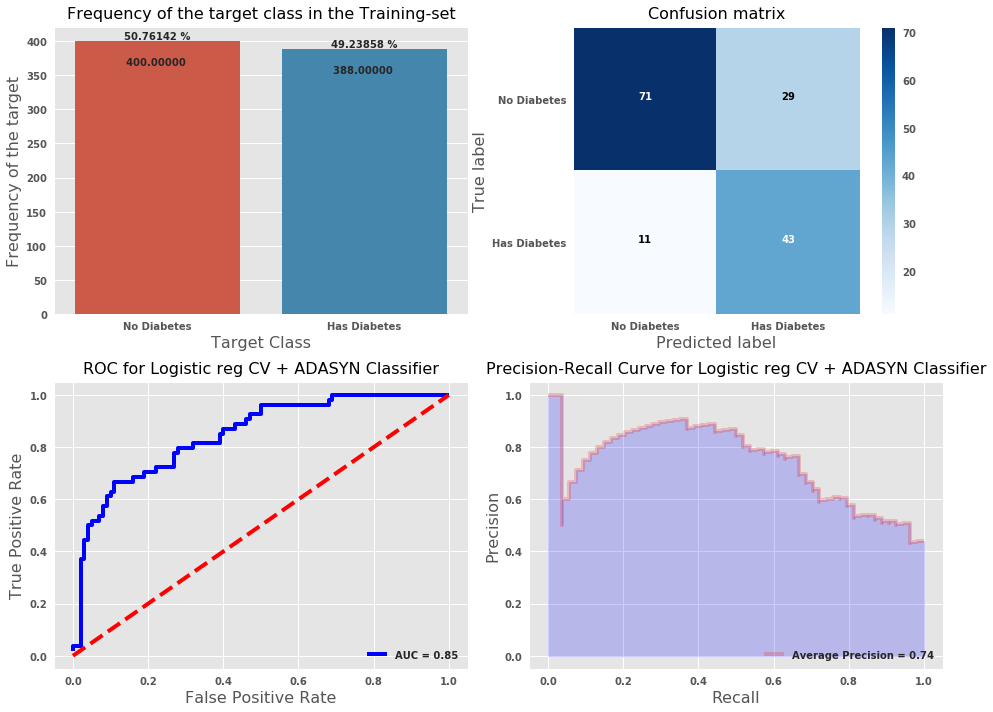

In [66]:
from sklearn.linear_model import LogisticRegressionCV
lgcv=LogisticRegressionCV(cv=5,scoring=scored)
lg_predictions=model_fitting_and_post_processing(lgcv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Logistic reg CV + ADASYN',class_names=['No Diabetes','Has Diabetes'],cross_val=False)